In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import datetime
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
import math
from sklearn.utils import shuffle
from sklearn.linear_model import Ridge
from sklearn.preprocessing import scale

# Data Preprocessing

In [3]:
file = os.getcwd()+"/../data/029720-99999_allYrs_Avg.txt"
dat = pd.read_csv(file,header=None,names=["lat", "lon", "elevation","date","dir","spd","gus","temp","slp"])

In [4]:
dat.head()

,lat,lon,elevation,date,dir,spd,gus,temp,slp
0,60.514,22.263,49.1,19020101,2.199135,23.700998,***,30.200000,994.28
1,60.514,22.263,49.1,19020102,2.443461,6.800000,***,17.200000,993.96
2,60.514,22.263,49.1,19020103,2.208953,9.938701,***,-0.200000,1005.08
3,60.514,22.263,49.1,19020104,3.949456,23.453623,***,28.733333,985.386666667
4,60.514,22.263,49.1,19020105,4.417350,5.170652,***,30.466667,978.293333333


In [5]:
#switch date to datetime object
dat['date'] = pd.to_datetime(dat['date'],format = '%Y%m%d')

In [6]:
dat.head()

,lat,lon,elevation,date,dir,spd,gus,temp,slp
0,60.514,22.263,49.1,1902-01-01,2.199135,23.700998,***,30.200000,994.28
1,60.514,22.263,49.1,1902-01-02,2.443461,6.800000,***,17.200000,993.96
2,60.514,22.263,49.1,1902-01-03,2.208953,9.938701,***,-0.200000,1005.08
3,60.514,22.263,49.1,1902-01-04,3.949456,23.453623,***,28.733333,985.386666667
4,60.514,22.263,49.1,1902-01-05,4.417350,5.170652,***,30.466667,978.293333333


In [7]:
#Add more date columns for specific analyses
dat['year'] = pd.DatetimeIndex(dat['date']).year
dat['month'] = pd.DatetimeIndex(dat['date']).month
dat['day'] = pd.DatetimeIndex(dat['date']).day
dat['dayOfYear'] = pd.DatetimeIndex(dat['date']).dayofyear
dat['dir']=dat['dir']*(180/math.pi)


#Replace *** with NaN's 
dat = dat.replace('***',np.nan)

In [8]:
dat.head()

,lat,lon,elevation,date,dir,spd,gus,temp,slp,year,month,day,dayOfYear
0,60.514,22.263,49.1,1902-01-01,126.001139,23.700998,NaN,30.200000,994.28,1902,1,1,1
1,60.514,22.263,49.1,1902-01-02,140.000000,6.800000,NaN,17.200000,993.96,1902,1,2,2
2,60.514,22.263,49.1,1902-01-03,126.563681,9.938701,NaN,-0.200000,1005.08,1902,1,3,3
3,60.514,22.263,49.1,1902-01-04,226.287188,23.453623,NaN,28.733333,985.386666667,1902,1,4,4
4,60.514,22.263,49.1,1902-01-05,253.095503,5.170652,NaN,30.466667,978.293333333,1902,1,5,5


In [9]:
#As a horrible person, I'm going to assume there are always 365 days in a year and throw out some leap years!
dayOfYrDic ={}

for i in range(365):
    dayOfYrDic[i+1]= dat[dat['dayOfYear']==i+1]

In [10]:
dayOfYrDic[9].head()

,lat,lon,elevation,date,dir,spd,gus,temp,slp,year,month,day,dayOfYear
8,60.514,22.263,49.1,1902-01-09,270.000000,14.200000,NaN,28.133333,999.28,1902,1,9,9
373,60.514,22.263,49.1,1903-01-09,290.000000,19.333333,NaN,28.466667,993.253333333,1903,1,9,9
738,60.514,22.263,49.1,1904-01-09,156.813859,15.999506,NaN,25.333333,1014.12,1904,1,9,9
1104,60.514,22.263,49.1,1905-01-09,281.418642,15.477500,NaN,35.266667,976.673333333,1905,1,9,9
1466,60.514,22.263,49.1,1952-01-09,212.504429,17.150734,NaN,39.263158,993.923684211,1952,1,9,9


# Wind Speed Prediction

### Here we utilize gust, temp, direction, and slp as features

7.85809372231 5.50465083454


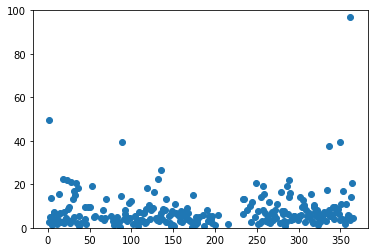

In [23]:
#This one for plot
npSqrtMSE = np.zeros(365)
npSqrtMSE = [-100.0 for x in npSqrtMSE]
npSqrtMSE = np.array(npSqrtMSE)

#This is one for mean
sqrtMSE = []
for i in range(365):
    df = dayOfYrDic[i+1][['gus','temp','dir','slp','spd']]
    df = df.dropna()
    X = df[['gus','temp','dir','slp']]
    y = df[['spd']]
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.25, random_state = 1, shuffle = True)
    if len(X_train)<5:
        continue
    #lm = LinearRegression()
    
    lm = Ridge(alpha = 0.2)
    lm.fit(X = X_train, y = y_train)
    y_pred = cross_val_predict(lm,X_train,y_train,cv=5)
    er = math.sqrt(mean_squared_error(y_pred,y_train))
    sqrtMSE.append(er)
    npSqrtMSE[i] = er

#Calculate average sqrt(MSE)
sqrtMSE = np.array(sqrtMSE)
avgSqrtMSE = np.mean(sqrtMSE)
medSqrtMSE = np.median(sqrtMSE)

print(avgSqrtMSE, medSqrtMSE)

#plt the errors
day = np.linspace(1,365,365)
plt.scatter(day,npSqrtMSE)
plt.ylim(0,100)
plt.show()

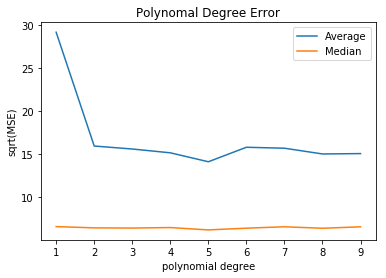

In [12]:
#Need to figure out what degree polynomial to use...
degreeList =[1,2,3,4,5,6,7,8,9]

avgList =[]
medList = []
for degree in degreeList:
    #This is one for mean
    sqrtMSE = []
    for i in range(365):
        df = dayOfYrDic[i+1][['gus','temp','dir','slp','spd']]
        df = df.dropna()
        X = df[['gus','temp','dir','slp']]
        y = df[['spd']]
        poly = PolynomialFeatures(degree = degree)
        X_ = poly.fit_transform(X)
        X_train, X_test, y_train, y_test = train_test_split(X_,y,test_size = 0.25, random_state = 1, shuffle = True)
        if len(X_train)<5:
            continue
        lm = LinearRegression()
        lm.fit(X = X_train, y = y_train)
        y_pred = cross_val_predict(lm,X_train,y_train,cv=5)
        er = math.sqrt(mean_squared_error(y_pred,y_train))
        sqrtMSE.append(er)

    #Calculate average and median sqrt(MSE)
    sqrtMSE = np.array(sqrtMSE)
    avgSqrtMSE = np.mean(sqrtMSE)
    medSqrtMSE = np.median(sqrtMSE)

    avgList.append(avgSqrtMSE)
    medList.append(medSqrtMSE)
    

plt.plot(degreeList,avgList,label="Average")
plt.plot(degreeList,medList,label="Median")
plt.ylabel("sqrt(MSE)")
plt.xlabel("polynomial degree")
plt.title("Polynomal Degree Error")
plt.legend()
plt.show()

### We should use use degree 5

15.9320482544 6.46915192604


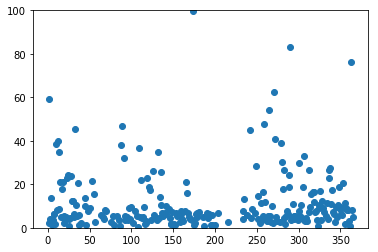

TESTING IS DONE BELOW.  THIS WAS PERFORMED AFTER OPTIMIZATION
Average R^2 vale (test set):  -1277.51453061

Median R^2 value (test set):  -13.7024810393

Average RMSE (test set):  17.5834067724

Median RMSE (test set):  7.34209761493


In [26]:
#This one for plot
npSqrtMSE = np.zeros(365)
npSqrtMSE = [-100.0 for x in npSqrtMSE]
npSqrtMSE = np.array(npSqrtMSE)

#This is one for mean
sqrtMSE = []

#These lists are for testing
testScore=[]
testRMSE = []
for i in range(365):
    df = dayOfYrDic[i+1][['gus','temp','dir','slp','spd']]
    df = df.dropna()
    X = df[['gus','temp','dir','slp']]
    y = df[['spd']]
    poly = PolynomialFeatures(degree =2)
    X_ = poly.fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X_,y,test_size = 0.25, random_state = 1, shuffle = True)
    if len(X_train)<5:
        continue
    #lm = LinearRegression()
    lm = Ridge()
    lm.fit(X = X_train, y = y_train)
    y_pred = cross_val_predict(lm,X_train,y_train,cv=5)
    er = math.sqrt(mean_squared_error(y_pred,y_train))
    sqrtMSE.append(er)
    npSqrtMSE[i] = er
    
    #below if for testing
    #the following was implemented after optimization
    score = lm.score(X=X_test, y = y_test)
    testScore.append(score)
    
    y_predict = lm.predict(X_test)
    rmse = math.sqrt(mean_squared_error(y_predict,y_test))
    testRMSE.append(rmse)

    

#Calculate average sqrt(MSE)
sqrtMSE = np.array(sqrtMSE)
avgSqrtMSE = np.mean(sqrtMSE)
medSqrtMSE = np.median(sqrtMSE)

print(avgSqrtMSE, medSqrtMSE)

#plt the errors
day = np.linspace(1,365,365)
plt.scatter(day,npSqrtMSE)
plt.ylim(0,100)
plt.show()

#below if for testing
testScore = np.array(testScore)
testRMSE = np.array(testRMSE)
scoreMean = np.mean(testScore)
rmseMean = np.mean(testRMSE)
scoreMed = np.median(testScore)
rmseMed = np.median(testRMSE)
print("TESTING IS DONE BELOW.  THIS WAS PERFORMED AFTER OPTIMIZATION")

print("Average R^2 vale (test set): ",scoreMean)
print()
print("Median R^2 value (test set): ",scoreMed)
print()
print("Average RMSE (test set): ", rmseMean)
print()
print("Median RMSE (test set): ", rmseMed)


Put simply:

When R2<0R2<0, a horizontal line explains the data better than your model.
You also asked about R2=0R2=0.

When R2=0R2=0, a horizontal line explains the data equally as well as your model.

### Taking out gust since it has the most NaN values

4.18841537028 4.085667389


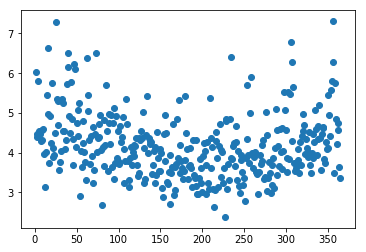

TESTING IS DONE BELOW.  THIS WAS PERFORMED AFTER OPTIMIZATION
Average R^2 vale (test set):  -0.253770004727

Median R^2 value (test set):  -0.125269808568

Average RMSE (test set):  3.74636508737

Median RMSE (test set):  3.64689244058


In [14]:
#This one for plot
npSqrtMSE = np.zeros(365)
npSqrtMSE = [-100.0 for x in npSqrtMSE]
npSqrtMSE = np.array(npSqrtMSE)

#This is one for mean
sqrtMSE = []

#These lists are for testing
testScore=[]
testRMSE = []

for i in range(365):
    df = dayOfYrDic[i+1][['temp','dir','slp','spd']]
    df = df.dropna()
    X = df[['temp','dir','slp']]
    y = df[['spd']]
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.25, random_state = 1, shuffle = True)
    if len(X_train)<5:
        continue
    lm = LinearRegression()
    lm.fit(X = X_train, y = y_train)
    y_pred = cross_val_predict(lm,X_train,y_train,cv=5)
    er = math.sqrt(mean_squared_error(y_pred,y_train))
    
    sqrtMSE.append(er)
    npSqrtMSE[i] = er
    
    #below if for testing
    #the following was implemented after optimization
    score = lm.score(X=X_test, y = y_test)
    testScore.append(score)
    
    y_predict = lm.predict(X_test)
    rmse = math.sqrt(mean_squared_error(y_predict,y_test))
    testRMSE.append(rmse)

#Calculate average sqrt(MSE)
sqrtMSE = np.array(sqrtMSE)
avgSqrtMSE = np.mean(sqrtMSE)
medSqrtMSE = np.median(sqrtMSE)

print(avgSqrtMSE, medSqrtMSE)

#plt the errors
day = np.linspace(1,365,365)
plt.scatter(day,npSqrtMSE)
#plt.ylim(0,100)
plt.show()

#below if for testing
testScore = np.array(testScore)
testRMSE = np.array(testRMSE)
scoreMean = np.mean(testScore)
rmseMean = np.mean(testRMSE)
scoreMed = np.median(testScore)
rmseMed = np.median(testRMSE)
print("TESTING IS DONE BELOW.  THIS WAS PERFORMED AFTER OPTIMIZATION")

print("Average R^2 vale (test set): ",scoreMean)
print()
print("Median R^2 value (test set): ",scoreMed)
print()
print("Average RMSE (test set): ", rmseMean)
print()
print("Median RMSE (test set): ", rmseMed)

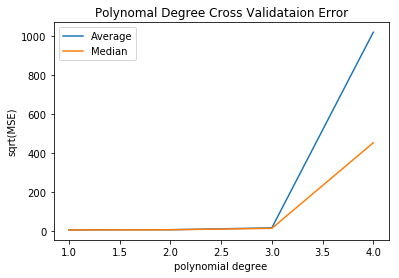

In [15]:
#Need to figure out what degree polynomial to use...
degreeList =[1,2,3,4]

avgList =[]
medList = []
for degree in degreeList:
    #This is one for mean
    sqrtMSE = []
    for i in range(365):
        df = dayOfYrDic[i+1][['temp','dir','slp','spd']]
        df = df.dropna()
        X = df[['temp','dir','slp']]
        y = df[['spd']]
        poly = PolynomialFeatures(degree = degree)
        X_ = poly.fit_transform(X)
        X_train, X_test, y_train, y_test = train_test_split(X_,y,test_size = 0.25, random_state = 1, shuffle = True)
        if len(X_train)<5:
            continue
        lm = LinearRegression()
        lm.fit(X = X_train, y = y_train)
        y_pred = cross_val_predict(lm,X_train,y_train,cv=5)
        er = math.sqrt(mean_squared_error(y_pred,y_train))
        sqrtMSE.append(er)
        

    #Calculate average and median sqrt(MSE)
    sqrtMSE = np.array(sqrtMSE)
    avgSqrtMSE = np.mean(sqrtMSE)
    medSqrtMSE = np.median(sqrtMSE)

    avgList.append(avgSqrtMSE)
    medList.append(medSqrtMSE)
    

plt.plot(degreeList,avgList,label="Average")
plt.plot(degreeList,medList,label="Median")
plt.ylabel("sqrt(MSE)")
plt.xlabel("polynomial degree")
plt.title("Polynomal Degree Cross Validataion Error")
plt.legend()
plt.show()

### Doesn't seem like polynomial helps

### Let's try some features indivdually


### Gust

3.04841191327 2.82575302762


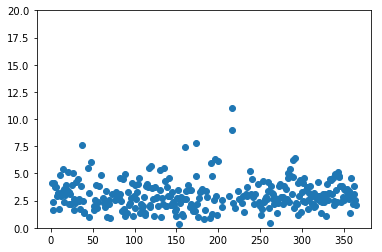

TESTING IS DONE BELOW.  THIS WAS PERFORMED AFTER OPTIMIZATION
Average R^2 vale (test set):  -77.8325408764

Median R^2 value (test set):  -0.499087773046

Average RMSE (test set):  2.80929627677

Median RMSE (test set):  2.57726884169


In [16]:
#This one for plot
npSqrtMSE = np.zeros(365)
npSqrtMSE = [-100.0 for x in npSqrtMSE]
npSqrtMSE = np.array(npSqrtMSE)

#This is one for mean
sqrtMSE = []

#These lists are for testing
testScore=[]
testRMSE = []

for i in range(365):
    df = dayOfYrDic[i+1][['gus','spd']]
    df = df.dropna()
    X = df[['gus']]
    y = df[['spd']]
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.25, random_state = 1, shuffle = True)
    if len(X_train)<5:
        continue
    lm = LinearRegression()
    lm.fit(X = X_train, y = y_train)
    y_pred = cross_val_predict(lm,X_train,y_train,cv=5)
    er = math.sqrt(mean_squared_error(y_pred,y_train))

    sqrtMSE.append(er)

    npSqrtMSE[i] = er
    
    #below if for testing
    #the following was implemented after optimization
    score = lm.score(X=X_test, y = y_test)
    testScore.append(score)
    
    y_predict = lm.predict(X_test)
    rmse = math.sqrt(mean_squared_error(y_predict,y_test))
    testRMSE.append(rmse)

#Calculate average sqrt(MSE)
sqrtMSE = np.array(sqrtMSE)
avgSqrtMSE = np.mean(sqrtMSE)
medSqrtMSE = np.median(sqrtMSE)

print(avgSqrtMSE, medSqrtMSE)

#plt the errors
day = np.linspace(1,365,365)
plt.scatter(day,npSqrtMSE)
plt.ylim(0,20)
plt.show()


#below if for testing
testScore = np.array(testScore)
testRMSE = np.array(testRMSE)
scoreMean = np.mean(testScore)
rmseMean = np.mean(testRMSE)
scoreMed = np.median(testScore)
rmseMed = np.median(testRMSE)

print("TESTING IS DONE BELOW.  THIS WAS PERFORMED AFTER OPTIMIZATION")

print("Average R^2 vale (test set): ",scoreMean)
print()
print("Median R^2 value (test set): ",scoreMed)
print()
print("Average RMSE (test set): ", rmseMean)
print()
print("Median RMSE (test set): ", rmseMed)

### Temperature

4.05174024984 3.97056929235


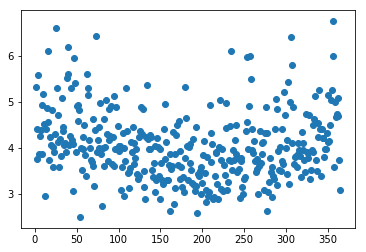

TESTING IS DONE BELOW.  THIS WAS PERFORMED AFTER OPTIMIZATION
Average R^2 vale (test set):  -0.124064777098

Median R^2 value (test set):  -0.0445364317404

Average RMSE (test set):  3.64844095133

Median RMSE (test set):  3.52830124523


In [17]:
#This one for plot
npSqrtMSE = np.zeros(365)
npSqrtMSE = [-100.0 for x in npSqrtMSE]
npSqrtMSE = np.array(npSqrtMSE)

#This is one for mean
sqrtMSE = []

#These lists are for testing
testScore=[]
testRMSE = []

for i in range(365):
    df = dayOfYrDic[i+1][['temp','spd']]
    df = df.dropna()
    X = df[['temp']]
    y = df[['spd']]
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.25, random_state = 1, shuffle = True)
    if len(X_train)<5:
        continue
    lm = LinearRegression()
    lm.fit(X = X_train, y = y_train)
    y_pred = cross_val_predict(lm,X_train,y_train,cv=5)
    er = math.sqrt(mean_squared_error(y_pred,y_train))
    sqrtMSE.append(er)
    npSqrtMSE[i] = er
    
    #below if for testing
    #the following was implemented after optimization
    score = lm.score(X=X_test, y = y_test)
    testScore.append(score)
    
    y_predict = lm.predict(X_test)
    rmse = math.sqrt(mean_squared_error(y_predict,y_test))
    testRMSE.append(rmse)

#Calculate average sqrt(MSE)
sqrtMSE = np.array(sqrtMSE)
avgSqrtMSE = np.mean(sqrtMSE)
medSqrtMSE = np.median(sqrtMSE)

print(avgSqrtMSE, medSqrtMSE)

#plt the errors
day = np.linspace(1,365,365)
plt.scatter(day,npSqrtMSE)
#plt.ylim(0,100)
plt.show()

#below if for testing
testScore = np.array(testScore)
testRMSE = np.array(testRMSE)
scoreMean = np.mean(testScore)
rmseMean = np.mean(testRMSE)
scoreMed = np.median(testScore)
rmseMed = np.median(testRMSE)

print("TESTING IS DONE BELOW.  THIS WAS PERFORMED AFTER OPTIMIZATION")

print("Average R^2 vale (test set): ",scoreMean)
print()
print("Median R^2 value (test set): ",scoreMed)
print()
print("Average RMSE (test set): ", rmseMean)
print()
print("Median RMSE (test set): ", rmseMed)

### Direction

4.11481386763 4.00248869851


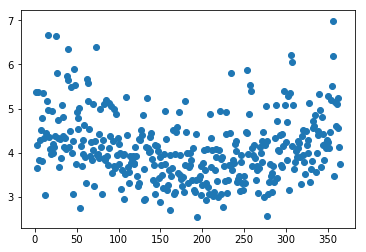

TESTING IS DONE BELOW.  THIS WAS PERFORMED AFTER OPTIMIZATION
Average R^2 vale (test set):  -0.18739574187

Median R^2 value (test set):  -0.0848790041261

Average RMSE (test set):  3.74916902284

Median RMSE (test set):  3.58556647609


In [18]:
#This one for plot
npSqrtMSE = np.zeros(365)
npSqrtMSE = [-100.0 for x in npSqrtMSE]
npSqrtMSE = np.array(npSqrtMSE)

#This is one for mean
sqrtMSE = []

#These lists are for testing
testScore=[]
testRMSE = []
for i in range(365):
    df = dayOfYrDic[i+1][['dir','spd']]
    df = df.dropna()
    X = df[['dir']]
    y = df[['spd']]
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.25, random_state = 1, shuffle = True)
    if len(X_train)<5:
        continue
    lm = LinearRegression()
    lm.fit(X = X_train, y = y_train)
    y_pred = cross_val_predict(lm,X_train,y_train,cv=5)
    er = math.sqrt(mean_squared_error(y_pred,y_train))
    sqrtMSE.append(er)
    npSqrtMSE[i] = er
        
    #below if for testing
    #the following was implemented after optimization
    score = lm.score(X=X_test, y = y_test)
    testScore.append(score)
    
    y_predict = lm.predict(X_test)
    rmse = math.sqrt(mean_squared_error(y_predict,y_test))
    testRMSE.append(rmse)

#Calculate average sqrt(MSE)
sqrtMSE = np.array(sqrtMSE)
avgSqrtMSE = np.mean(sqrtMSE)
medSqrtMSE = np.median(sqrtMSE)

print(avgSqrtMSE, medSqrtMSE)

#plt the errors
day = np.linspace(1,365,365)
plt.scatter(day,npSqrtMSE)

plt.show()

#below if for testing
testScore = np.array(testScore)
testRMSE = np.array(testRMSE)
scoreMean = np.mean(testScore)
rmseMean = np.mean(testRMSE)
scoreMed = np.median(testScore)
rmseMed = np.median(testRMSE)

print("TESTING IS DONE BELOW.  THIS WAS PERFORMED AFTER OPTIMIZATION")

print("Average R^2 vale (test set): ",scoreMean)
print()
print("Median R^2 value (test set): ",scoreMed)
print()
print("Average RMSE (test set): ", rmseMean)
print()
print("Median RMSE (test set): ", rmseMed)

4.13199595309 4.02598494728


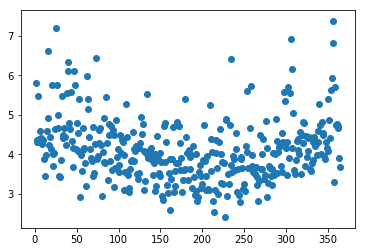

TESTING IS DONE BELOW.  THIS WAS PERFORMED AFTER OPTIMIZATION
Average R^2 vale (test set):  -0.189117274115

Median R^2 value (test set):  -0.0681903136049

Average RMSE (test set):  3.67606201891

Median RMSE (test set):  3.58290965439


In [19]:
#This one for plot
npSqrtMSE = np.zeros(365)
npSqrtMSE = [-100.0 for x in npSqrtMSE]
npSqrtMSE = np.array(npSqrtMSE)

#This is one for mean
sqrtMSE = []

#These lists are for testing
testScore=[]
testRMSE = []
for i in range(365):
    df = dayOfYrDic[i+1][['slp','spd']]
    df = df.dropna()
    X = df[['slp']]
    y = df[['spd']]
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.25, random_state = 1, shuffle = True)
    if len(X_train)<5:
        continue
    lm = LinearRegression()
    lm.fit(X = X_train, y = y_train)
    y_pred = cross_val_predict(lm,X_train,y_train,cv=5)
    er = math.sqrt(mean_squared_error(y_pred,y_train))
    sqrtMSE.append(er)
    npSqrtMSE[i] = er
            
    #below if for testing
    #the following was implemented after optimization
    score = lm.score(X=X_test, y = y_test)
    testScore.append(score)
    
    y_predict = lm.predict(X_test)
    rmse = math.sqrt(mean_squared_error(y_predict,y_test))
    testRMSE.append(rmse)

#Calculate average sqrt(MSE)
sqrtMSE = np.array(sqrtMSE)
avgSqrtMSE = np.mean(sqrtMSE)
medSqrtMSE = np.median(sqrtMSE)

print(avgSqrtMSE, medSqrtMSE)

#plt the errors
day = np.linspace(1,365,365)
plt.scatter(day,npSqrtMSE)

plt.show()

#below if for testing
testScore = np.array(testScore)
testRMSE = np.array(testRMSE)
scoreMean = np.mean(testScore)
rmseMean = np.mean(testRMSE)
scoreMed = np.median(testScore)
rmseMed = np.median(testRMSE)

print("TESTING IS DONE BELOW.  THIS WAS PERFORMED AFTER OPTIMIZATION")

print("Average R^2 vale (test set): ",scoreMean)
print()
print("Median R^2 value (test set): ",scoreMed)
print()
print("Average RMSE (test set): ", rmseMean)
print()
print("Median RMSE (test set): ", rmseMed)

# Check out the distriubution

In [20]:
dayMean = np.zeros(365)
dayMean = [-100.0 for x in dayMean]
dayMean = np.array(dayMean)

for i in range(365):
    yrSpd = dayOfYrDic[i+1]['spd']
    yrSpd = np.array(yrSpd)
    dayMean[i] = np.mean(yrSpd)
    

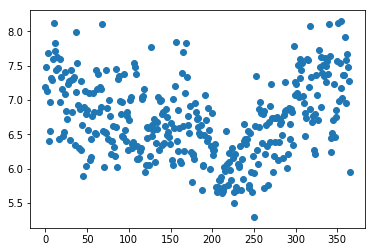

In [21]:
plt.scatter(np.linspace(0,len(dayMean),len(dayMean)),dayMean)
plt.show()

# Testing